In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np
import IPython.display as display

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import imageio



In [2]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"DQN{CHECKPOINT}_investigation"
# MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044157/runs/dqn_1.38_3_grid_4_ep_len__filter_quarter"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_4_grid_4_ep_len__filter_"

EPOCHS = 51
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
# os.makedirs(GIF_PATH, exist_ok=True)


In [3]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=4,
        number_of_boxes_min=1,
        number_of_boxes_max=1,
        number_of_moving_boxes_max=1
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [4]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.agent.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),  # Add batch dimension
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8)
    * (env._env.action_space - 1),  # it should be the maximal value of action space
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_4_grid_4_ep_len__filter_/params_50.pkl


In [5]:
# Create env once again with correct config and collect data
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)


In [6]:
def display_state(state, action_q_values=None, save_path=None):
# def display_state(state, action_q_values=None):
    img_prefix="/home/mbortkie/repos/crl_subgoal/assets"
    fig, ax = plt.subplots(figsize=(5, 5))
    grid_state = state

    imgs = {
        int(GridStatesEnum.EMPTY): "floor.png",
        int(GridStatesEnum.BOX): "box.png",
        int(GridStatesEnum.TARGET): "box_target.png",
        int(GridStatesEnum.AGENT): "agent.png",
        int(GridStatesEnum.AGENT_CARRYING_BOX): "agent_carrying_box.png",
        int(GridStatesEnum.AGENT_ON_BOX): "agent_on_box.png",
        int(GridStatesEnum.AGENT_ON_TARGET): "agent_on_target.png",
        int(GridStatesEnum.AGENT_ON_TARGET_CARRYING_BOX): "agent_on_target_carrying_box.png",
        int(GridStatesEnum.AGENT_ON_TARGET_WITH_BOX): "agent_on_target_with_box.png",
        int(GridStatesEnum.AGENT_ON_TARGET_WITH_BOX_CARRYING_BOX): "agent_on_target_with_box_carrying_box.png",
        int(GridStatesEnum.BOX_ON_TARGET): "box_on_target.png",
        int(GridStatesEnum.AGENT_ON_BOX_CARRYING_BOX): "agent_on_box_carrying_box.png",
    }

    rows, cols = grid_state.shape[0], grid_state.shape[1]

    # Plot grid: col -> x axis, row -> y axis
    for row in range(rows):
        for col in range(cols):
            img_name = imgs[int(grid_state[row, col])]
            img_path = os.path.join(img_prefix, img_name)
            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                ax.imshow(img, extent=[col, col + 1, row, row + 1])
            else:
                # fallback: draw a rectangle if file missing
                ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=True, edgecolor='k', facecolor='0.05'))

    # Find agent position(s) by checking file names that contain "agent"
    agent_keys = [k for k, name in imgs.items() if 'agent' in name.lower()]
    agent_pos = None
    for row in range(rows):
        for col in range(cols):
            if int(grid_state[row, col]) in agent_keys:
                agent_pos = (col, row)  # col -> x, row -> y
                break
        if agent_pos is not None:
            break

    if action_q_values is not None and agent_pos is not None:
        # Accept dict {action: q} or list/array
        actions = ["Up", "Down", "Left", "Right", "Pickup", "Drop"]
        if isinstance(action_q_values, dict):
            qvals = np.array([action_q_values.get(a, 0.0) for a in actions], dtype=float)
        else:
            qvals = np.array(action_q_values, dtype=float)
            if qvals.shape[0] != len(actions):
                raise ValueError(f"action_q_values length {qvals.shape[0]} != {len(actions)} actions")

        # Which action is best? (first argmax if ties)
        best_idx = int(np.argmax(qvals))

        # Normalize for arrow length (preserve sign for color mapping)
        q_min, q_max = qvals.min(), qvals.max()
        if q_max == q_min:
            norm_lengths = np.ones_like(qvals) * 0.6  # uniform small length
        else:
            # scale lengths to [0.15, 0.8]
            norm_lengths = 0.15 + 0.65 * (qvals - q_min) / (q_max - q_min)

        # Color map: map qvals to colors
        cmap = cm.get_cmap("coolwarm")
        norm = mcolors.Normalize(vmin=q_min, vmax=q_max)
        colors = cmap(norm(qvals))

        # center of the agent cell
        ax_x = agent_pos[0] + 0.5
        ax_y = agent_pos[1] + 0.5

        # mapping of actions to vector directions in plot coordinates
        # Note: Up has dy = -1 to visually go up after invert_yaxis()
        dir_vecs = {
            "Up": (0.0, -1.0),
            "Down": (0.0,  1.0),
            "Left": (-1.0, 0.0),
            "Right": (1.0, 0.0),
        }

        # Fixed label offsets (always the same place relative to agent)
        fixed_label_offsets = {
            "Up":    (0.0, -0.65),
            "Down":  (0.0,  0.65),
            "Left":  (-0.65, 0.0),
            "Right": (0.65, 0.0),
            "Pickup": (-0.6, -0.6),
            "Drop":   (0.6,  -0.6),  # choose positions that don't overlap too much
        }

        # Draw directional arrows (Up/Down/Left/Right)
        for i, name in enumerate(["Up", "Down", "Left", "Right"]):
            dx_unit, dy_unit = dir_vecs[name]
            # length = norm_lengths[i]
            length = 0.6
            dx = dx_unit * length
            dy = dy_unit * length
            color = colors[i]

            # highlight style for best action
            is_best = (i == best_idx)

            # start slightly offset so arrow doesn't start exactly at center
            start_x = ax_x - 0.12 * dx_unit
            start_y = ax_y - 0.12 * dy_unit
            end_x = start_x + dx
            end_y = start_y + dy

            arr = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                  arrowstyle='-|>', mutation_scale=15 * (0.9 + 0.4 * length),
                                  linewidth=(3.5 if is_best else 2.0),
                                  color=color, alpha=(1.0 if is_best else 0.95), zorder=4)
            ax.add_patch(arr)

            # place Q-value text at fixed position relative to agent (not moving with Q)
            lbl_off = fixed_label_offsets[name]
            txt_x = ax_x + lbl_off[0]
            txt_y = ax_y + lbl_off[1]
            bbox = dict(boxstyle="round,pad=0.15", fc='white', alpha=0.75, linewidth=0)
            # give a subtle highlight box for the best action
            if is_best:
                bbox['edgecolor'] = 'gold'
                bbox['linewidth'] = 3.0
            ax.text(txt_x, txt_y, f"{int(qvals[i])}", fontsize=9, ha='center', va='center', bbox=bbox, zorder=5)

        # Draw Pickup / Drop as small circles (with fixed positions) and labels
        for i, name in enumerate(["Pickup", "Drop"], start=4):
            is_best = (i == best_idx)
            offset = fixed_label_offsets[name]
            cx = ax_x + offset[0]
            cy = ax_y + offset[1]
            radius = 0.18 + 0.12 * norm_lengths[i]
            # if best, draw a thicker gold outline behind
            if is_best:
                # outline circle
                outline = Circle((cx, cy), radius=radius + 0.06, linewidth=3.0, edgecolor='gold', facecolor='none', zorder=3)
                ax.add_patch(outline)

            circ = Circle((cx, cy), radius=radius, linewidth=(2.5 if is_best else 1.3),
                          edgecolor='k', facecolor=colors[i], alpha=(1.0 if is_best else 0.9), zorder=4)
            ax.add_patch(circ)
            ax.text(cx, cy, f"{name[0]}\n{int(qvals[i])}", fontsize=7, ha='center', va='center', color='white', zorder=5)

        # Add small colorbar legend
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Q value')

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect("equal")
    ax.invert_yaxis()  # keep (0,0) at top-left like array indexing; remove if you prefer origin at bottom-left
    plt.tight_layout()
    plt.show()


    # convert to array
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))

    plt.close(fig)
    if save_path:
        plt.imsave(save_path, frame)
    return frame

In [7]:
def play_game(env, key: jax.Array):
    """Interactive game loop using input() for controls."""

    # Initialize the environment
    state, _ = env.reset(key)
    done = False
    info = {}
    total_reward = 0
    reward = 0

    print("=== Box Pushing Game ===")
    print("Controls: w(up), s(down), a(left), d(right), e(pickup), r(drop)")
    print("Press 'q' to quit\n")

    while True:
        # Display current state
        grid=remove_targets(state.grid)
        goal=remove_targets(state.goal)
        all_actions = jnp.tile(jnp.arange(6), (1, 1))  # B x 6
        qs = jax.lax.stop_gradient(
            jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(jnp.expand_dims(grid.flatten(), 0), jnp.expand_dims(goal.flatten(), 0), all_actions)
        )  # 6 x 2 x B
        qs = qs.mean(axis=1)  # 6 x B
        best = int(jnp.argmax(qs[:, 0]))
        print("Q-values:")
        for i, action_name in enumerate(["Up", "Down", "Left", "Right", "Pickup", "Drop"]):
            star = "*" if i == best else " "
            print(f"  {action_name}{star}: {qs[i,0]:.2f}")

        display_state(state.grid, qs[:, 0])
        no_targets = remove_targets(state.grid)
        print(no_targets)
        print(f"Steps: {state.steps}, Return: {total_reward}, Reward: {reward}")
        print(f"Info: {info}, Done: {done}")

        # Get user input
        action = None
        while action is None:
            try:
                user_input = input("Enter action (w/s/a/d/e/r/q/g): ").lower().strip()
                if user_input == "w":
                    action = 0  # Up
                elif user_input == "s":
                    action = 1  # Down
                elif user_input == "a":
                    action = 2  # Left
                elif user_input == "d":
                    action = 3  # Right
                elif user_input == "e":
                    action = 4  # Pickup
                elif user_input == "r":
                    action = 5  # Drop
                elif user_input == "q":
                    print("Game ended by user.")
                    return
                elif user_input == "g":
                    print("Game restarted by user.")
                    action = "restart"
                else:
                    print("Invalid input. Use w/s/a/d/e/r/q/g")
            except (EOFError, KeyboardInterrupt):
                print("\nGame ended by user.")
                return

        # Take action
        if action == "restart":
            state, info = env.reset(state.key)
        else:
            state, reward, done, info = env.step(state, action)
            total_reward += reward

=== Box Pushing Game ===
Controls: w(up), s(down), a(left), d(right), e(pickup), r(drop)
Press 'q' to quit

Q-values:
  Up : 81.77
  Down : 83.41
  Left : 81.85
  Right : 82.38
  Pickup*: 83.43
  Drop : 82.61


/tmp/ipykernel_2219009/3579020092.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


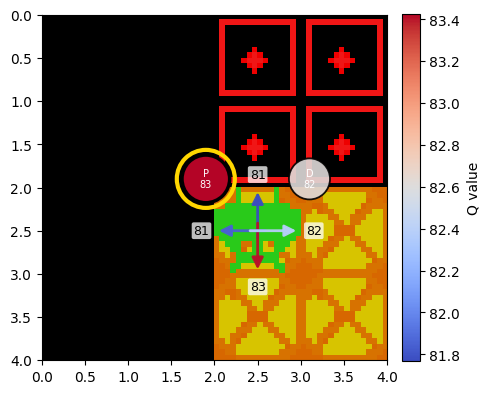

[[0 0 0 0]
 [0 0 0 0]
 [0 0 5 1]
 [0 0 1 1]]
Steps: 0, Return: 0, Reward: 0
Info: {}, Done: False
Q-values:
  Up*: 84.29
  Down : 82.79
  Left : 82.70
  Right : 83.07
  Pickup : 83.27
  Drop : 82.75


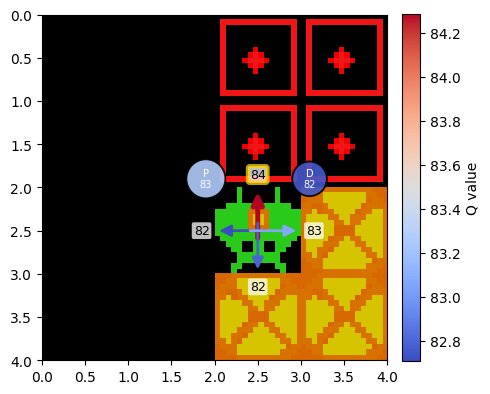

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 1]
 [0 0 1 1]]
Steps: 1, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(0, dtype=int32), 'truncated': Array(False, dtype=bool)}, Done: False
Game ended by user.


In [8]:
play_game(env, key)

In [21]:
import imageio
import numpy as np
import jax
import jax.numpy as jnp

def create_gif(
    env,
    agent,
    state,
    steps: int = 20,
    filename: str = "trajectory.gif",
    duration: float = 0.5,
    policy: str = "argmax",         # "argmax" or "softmax"
    rng_key = None,  # optional JAX PRNGKey for reproducible softmax sampling
):
    """
    Run the environment from `state`, compute Qs each step, choose actions according to `policy`,
    capture frames with display_state(...), and save a GIF.

    Args:
      policy: "argmax" (choose highest-Q) or "softmax" (sample from softmax(Q/temperature)).
      temperature: positive float used when policy == "softmax".
      rng_key: optional JAX PRNGKey. If provided and policy == "softmax", sampling uses JAX and the key
               is split each step for reproducibility. If not provided, NumPy's RNG is used.
    Returns:
      filename (str) where GIF was saved.
    """
    frames = []
    state_local = state  # avoid mutating caller's reference unintentionally
    key = rng_key

    for t in range(steps):
        # --- compute Q-values (exactly like your snippet) ---
        grid = remove_targets(state_local.grid)
        goal = remove_targets(state_local.goal)
        all_actions = jnp.arange(6).reshape(1, -1)  # B x 6 (1 x 6)
        qs = jax.lax.stop_gradient(
            jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(
                jnp.expand_dims(grid.flatten(), 0),
                jnp.expand_dims(goal.flatten(), 0),
                all_actions,
            )
        )
        qs = qs.mean(axis=1)  # shape: (6, B)
        q_col = qs[:, 0]      # shape: (6,)

        # --- choose action according to requested policy ---
        if policy == "argmax":
            action = int(jnp.argmax(q_col))
        elif policy == "softmax":
            temperature = agent.network.select('alpha_temp')()
            probs = jax.nn.softmax(q_col / temperature)
            # Use JAX sampling if a key was provided (reproducible), otherwise fallback to numpy
            if key is not None:
                key, subkey = jax.random.split(key)
                action = int(jax.random.choice(subkey, a=q_col.shape[0], p=probs))
            else:
                probs_np = np.array(probs)
                action = int(np.random.choice(np.arange(len(probs_np)), p=probs_np))
        else:
            raise ValueError(f"Unknown policy '{policy}'; choose 'argmax' or 'softmax'")

        # --- render frame and step env ---
        q_col_np = np.array(q_col)  # convert to numpy for display_state (if it expects numpy)
        # If your display_state returns a frame (as in prior snippets), use it directly:
        frame = display_state(state_local.grid, q_col_np)  # returns uint8 RGBA or RGB frame
        frames.append(frame)

        # step environment with chosen action
        state_local, reward, done, info = env.step(state_local, action)

        # optionally print / debug
        print(f"[t={t:02d}] policy={policy}, chosen_action={action}, q={list(map(float, q_col))}")

        if done:
            # render the final state too (optional)
            q_col_np = np.array(q_col)  # last q's (or recompute if you prefer)
            final_frame = display_state(state_local.grid, q_col_np)
            frames.append(final_frame)
            print("Episode finished at step", t)
            break

    if len(frames) == 0:
        raise RuntimeError("No frames captured; GIF not created.")

    # save GIF (duration = seconds per frame)
    imageio.mimsave(filename, frames, duration=duration)
    print(f"Saved GIF to {filename}")

    # return filename (and optionally updated key if you want reproducibility)
    # If you passed rng_key and want the final key back, return (filename, key).
    if rng_key is not None:
        return filename, key
    return filename


/tmp/ipykernel_2219009/3579020092.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


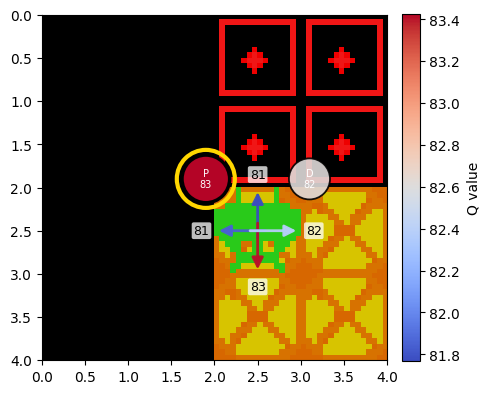

[t=00] policy=softmax, chosen_action=1, q=[81.76640319824219, 83.40555572509766, 81.84651184082031, 82.37710571289062, 83.42716217041016, 82.61347961425781]


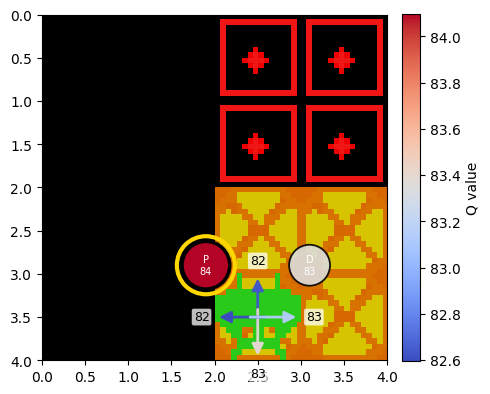

[t=01] policy=softmax, chosen_action=4, q=[82.63154602050781, 83.39106750488281, 82.59458923339844, 83.13507080078125, 84.09837341308594, 83.34477233886719]


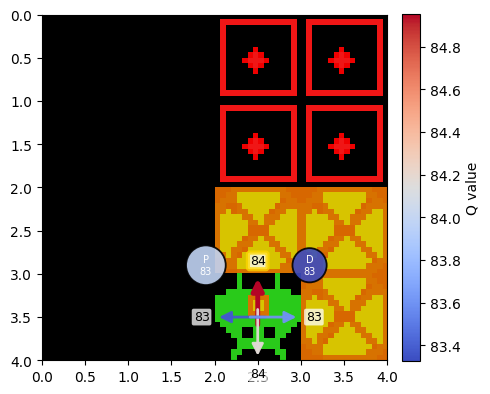

[t=02] policy=softmax, chosen_action=0, q=[84.95458984375, 84.16925048828125, 83.37762451171875, 83.59822082519531, 83.98663330078125, 83.32437133789062]


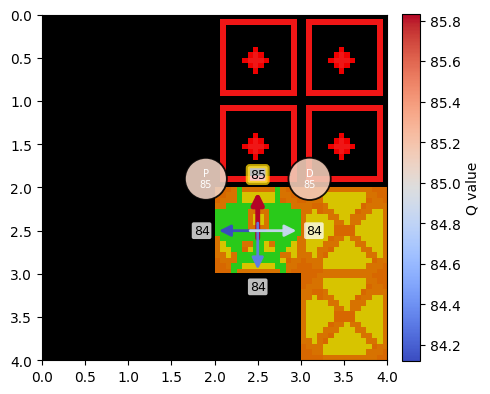

[t=03] policy=softmax, chosen_action=0, q=[85.83451080322266, 84.31659698486328, 84.11880493164062, 84.84721374511719, 85.10311889648438, 85.14607238769531]


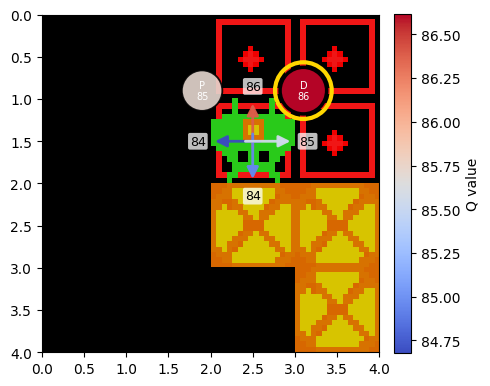

[t=04] policy=softmax, chosen_action=5, q=[86.39093017578125, 84.94876861572266, 84.67613220214844, 85.55581665039062, 85.71697235107422, 86.61891174316406]


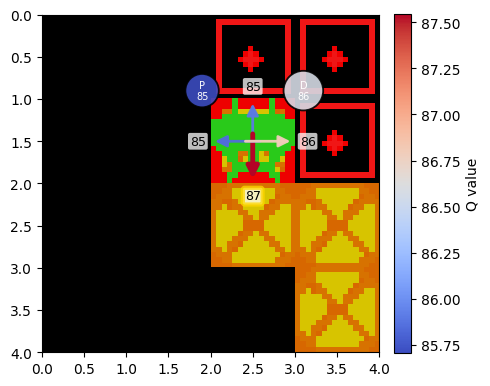

[t=05] policy=softmax, chosen_action=1, q=[85.8995361328125, 87.54702758789062, 85.8434829711914, 86.79402160644531, 85.70528411865234, 86.57475280761719]


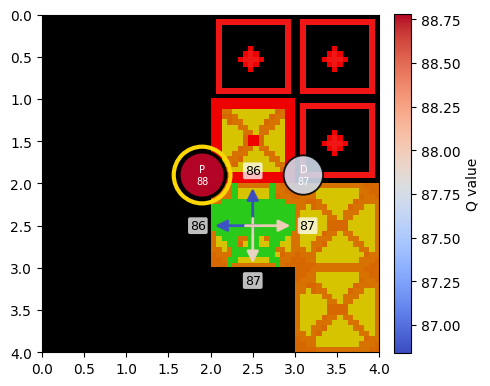

[t=06] policy=softmax, chosen_action=1, q=[86.83789825439453, 87.9362564086914, 86.86192321777344, 87.98963928222656, 88.7835693359375, 87.7193374633789]


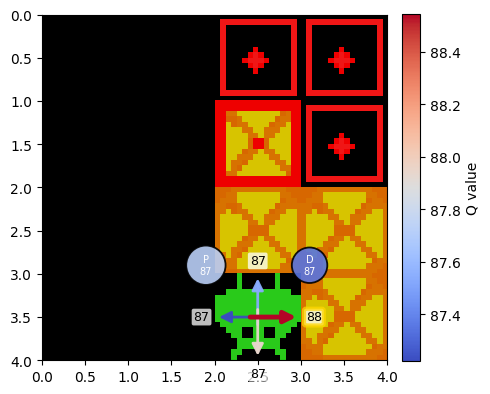

[t=07] policy=softmax, chosen_action=1, q=[87.53590393066406, 87.9449691772461, 87.22097778320312, 88.54620361328125, 87.72679138183594, 87.34689331054688]


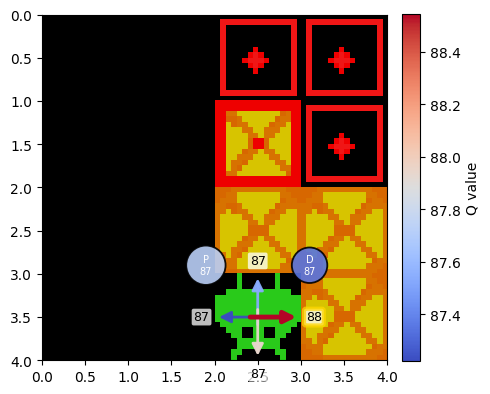

[t=08] policy=softmax, chosen_action=0, q=[87.53590393066406, 87.9449691772461, 87.22097778320312, 88.54620361328125, 87.72679138183594, 87.34689331054688]


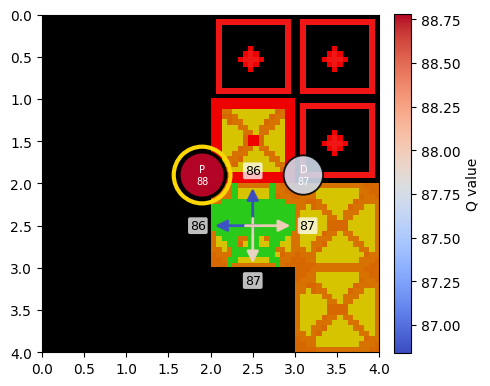

[t=09] policy=softmax, chosen_action=3, q=[86.83789825439453, 87.9362564086914, 86.86192321777344, 87.98963928222656, 88.7835693359375, 87.7193374633789]


KeyboardInterrupt: 

In [22]:
state, _ = env.reset(key)
out_path = create_gif(env, agent, state, filename="agent_q_rollout_dqn.gif", policy="softmax", steps=100)
